# Example Usage for Cleaning Stimulation Pulses with Zappy

# Main Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import scipy.stats as sp_stats

import zappy

# Load Data

In [ ]:
def get_stim_data():
    from tqdm import tqdm
    import wget
    import zipfile
    import os
    
    url = "https://www.dropbox.com/sh/yqf36798y1yz9e8/AACcqZdu09Chlvkr1NOFFsiQa?dl=1"
    out = './stim_24k.zip'
    fname = './data/EC206_B18_stim_example.npz'
    if not os.path.exists(fname):
        if not os.path.exists(out):
            print('Downloading sample data...')
            wget.download(url, out=out, bar=wget.bar_thermometer)
        
        print('Extracting sample data...')
        with zipfile.ZipFile(out, 'r') as zipObj:
            zipObj.extractall('./data')
            
        os.remove(out)
            
    npz = zappy.io.sigdict.load_data_dict(fname)
    print('Loaded sample data.')    
    
    return npz

# Download / load-in sample data
npz = get_stim_data()

# Get data sizes
n_time = npz['stim'].shape[0]
n_stim = npz['stim'].shape[1]
tstamp = np.arange(0, n_time / npz['Fs'], 1/npz['Fs'])

# Visualize Stimulation Pulses 

## Full Stim Sequence

In [ ]:
plt.figure(figsize=(24,12))
for i in range(n_stim):
    ax = plt.subplot(n_stim, 1, i+1)
    ax.plot(tstamp, npz['stim'][:,i])
    ax.set_ylim([-2500, 2500])
    
    if i < (n_stim-1):
        ax.set_xticks([])
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Stim Current (uA)')

## Zoomed-In Plot

In [ ]:
plt.figure(figsize=(24,12))
for i in range(n_stim):
    ax = plt.subplot(n_stim, 1, i+1)
    ax.plot(tstamp, npz['stim'][:,i])
    ax.set_ylim([-2500, 2500])
    
    if i < (n_stim-1):
        ax.set_xticks([])
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Stim Current (uA)')
    
    ax.set_xlim([45, 52])

In [2]:
sseq = np.load('/Users/akhambhati/Hoth/Remotes/CORE.VNS_Test.wschuerman/tVNS_30Hz/stim.npy')
sig_sham = np.load('/Users/akhambhati/Hoth/Remotes/CORE.VNS_Test.wschuerman/tVNS_30Hz/sig_sham.npy')
sig = np.load('/Users/akhambhati/Hoth/Remotes/CORE.VNS_Test.wschuerman/tVNS_30Hz/LFP.npy')

Fs = 24000
tstamp = np.arange(sig.shape[0]) / Fs

# Interpolation-based cleaning

In [21]:
### Handle the Dirac formulation
# Get the dirac stim representation
dirac = zappy.elstim.stim_blank.convert_seq_to_dirac(sseq[:,0]*-1)

# Epoch the stim data
epoch = zappy.elstim.stim_blank.epoch_stim_on_off(dirac, n_inter_pulse=800)

if epoch.any():
    # Grab the dirac representation during a stim-ON epoch
    on_start = np.flatnonzero(np.diff(epoch) == 1) + 1
    on_end = np.flatnonzero(np.diff(epoch) == -1) + 1
    dirac_stim_on = dirac[on_start[0]:on_end[0]]

    # Iterate over each inter epoch (on_end marks start, on_start marks end)
    on_end = np.concatenate(([0], on_end))
    on_start = np.concatenate((on_start, [len(epoch)]))
    for ep_ii, (ep_start, ep_end) in enumerate(zip(on_end, on_start)):
        dirac[ep_start:ep_end] = zappy.elstim.stim_blank.corrupt_stim_sample(
            dirac_stim_on, ep_end - ep_start)
        
# Get the dirac to fit the actual signal, and extend corrupt window
blank = zappy.elstim.stim_blank.corrupt_stim_sample(dirac, len(tstamp),
                            n_pre_pad=0, n_post_pad=0)        

# Apply a linear regression at the hold
new_sig = []
for sss in sig.T:
    new_sig.append(zappy.elstim.stim_blank.revinterp_blank(sss, blank))
new_sig = np.array(new_sig).T


# Decimate
new_sig_ds, Q = zappy.sigproc.filters.decimate(new_sig, fs_old=Fs, fs_new=1500)
Fs_new = Fs / Q
new_sig_ds, Q = zappy.sigproc.filters.decimate(new_sig_ds, fs_old=Fs_new, fs_new=1500)
Fs_new = Fs_new / Q
new_sig_ds, Q = zappy.sigproc.filters.decimate(new_sig_ds, fs_old=Fs_new, fs_new=1500)
Fs_new = Fs_new / Q

# Notch filter
# Notch line + harmonics
new_sig_ds = zappy.sigproc.filters.notch_line(new_sig_ds.reshape(-1,1), fs=Fs_new, notch_freq=60, bw=2, harm=True)
# Notch stim + harmonics
new_sig_ds = zappy.sigproc.filters.notch_line(new_sig_ds.reshape(-1,1), fs=Fs_new, notch_freq=30, bw=2, harm=True)

# CAR
#new_sig_ds = zappy.sigproc.reference.general_reref(new_sig_ds) 

# downsampled timestamps
tstamp_ds = np.arange(new_sig_ds.shape[0]) / Fs_new

## Check interpolation

(-200, 200)

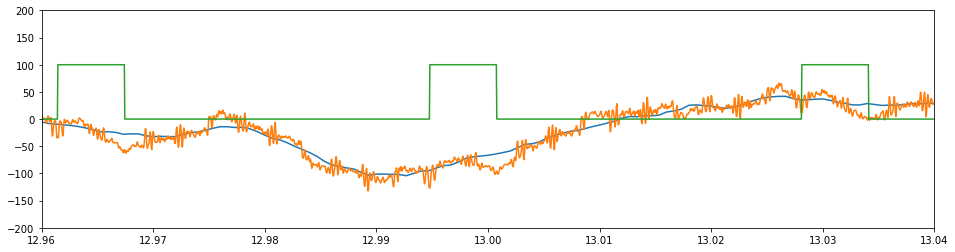

In [22]:
plt.figure(figsize=(16,4))
#plt.plot(tstamp, sseq*1000)
plt.plot(tstamp_ds, new_sig_ds[:,0])
plt.plot(tstamp, sig[:,0])
plt.plot(tstamp, blank*100)
plt.xlim(np.array([12.96, 13.04]))
plt.ylim(np.array([-200, 200]))

## Spectrogram

In [ ]:
sel_ts = np.flatnonzero((tstamp >= 0) & (tstamp <= 400))

plt.figure(figsize=(9,12))
ax = plt.subplot(3,1,1)
ax.plot(tstamp[sel_ts], sseq[sel_ts, 0])
ax.set_xlim([tstamp[sel_ts].min(), tstamp[sel_ts].max()])
ax.set_title('Stim Sequence')

ax = plt.subplot(3,1,2)
spec = ax.specgram(sig[sel_ts, 0], Fs=Fs, NFFT=2**15, noverlap=2**14)
ax.set_ylim([0, 200])
#ax.set_xlim([400.88-400, 400.9-400])
ax.set_title('Original')

ax = plt.subplot(3,1,3)
spec = ax.specgram(new_sig[sel_ts, 0], Fs=Fs, NFFT=2**15, noverlap=2**14)
ax.set_ylim([0, 200])
#ax.set_xlim([400.88-400, 400.9-400])
ax.set_title('Blank/LInterp')

In [ ]:
from scipy import signal

f, Pxx_den = signal.welch(sig[sel_ts, 0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(new_sig[sel_ts], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 200])
plt.ylim([10**(-3), 10**(4)])
plt.tight_layout()
plt.legend(['Original', 'Interp Clean'])
plt.show()

f, Pxx_den = signal.welch(sig[sel_ts, 0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(new_sig[sel_ts], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 100])
#plt.ylim([10**(-10), 10**(-7)])
plt.tight_layout()
plt.legend(['Original', 'Interp Clean'])
plt.show()

# Run Zappy

In [ ]:
signal_cleaned = zappy.elstim.artifact.ica_pulse_reconstruction(
                            signal=sig.copy(),
                            stim_seq=sseq.copy(),
                            amp_range=(0,1),
                            inter_train_len=Fs*8.0,
                            padding=[0, 0],
                            ic_stat_pct=[0, 100],
                            signal_sham=sig_sham.copy(),
                            n_components=None,
                            plot=True)

# Decimate Cleaned Signal

In [ ]:
import scipy.signal as sp_sig
signal_cleaned2 = np.convolve(signal_cleaned[:,0], sp_sig.windows.hann(10)/10, mode='same').reshape(-1,1)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(tstamp, sig[:, 0])
plt.plot(tstamp, signal_cleaned[:, 0])
#plt.xlim([110.210, 110.225])
#plt.xlim([210.7, 211.2])
#plt.xlim([400.7, 401.2])
plt.xlim([400.88, 400.9])
#plt.ylim([-250, 250])
#plt.legend(['Original', 'Zappy'])
plt.show()

In [ ]:
sel_ts = np.flatnonzero((tstamp >= 400) & (tstamp <= 460))

plt.figure(figsize=(9,12))
ax = plt.subplot(3,1,1)
ax.plot(tstamp[sel_ts], sseq[sel_ts, 0])
ax.set_xlim([400, 460])
ax.set_title('Stim Sequence')

ax = plt.subplot(3,1,2)
ax.specgram(sig[sel_ts, 0], Fs=Fs, NFFT=2**15, noverlap=2**14)
ax.set_ylim([0, 200])
#ax.set_xlim([400.88-400, 400.9-400])
ax.set_title('Original')

ax = plt.subplot(3,1,3)
ax.specgram(signal_cleaned[sel_ts, 0], Fs=Fs, NFFT=2**15, noverlap=2**14)
ax.set_ylim([0, 200])
#ax.set_xlim([400.88-400, 400.9-400])
ax.set_title('Zappy')

In [ ]:
from scipy import signal

f, Pxx_den = signal.welch(sig[sel_ts, 0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(signal_cleaned[sel_ts,0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 200])
plt.ylim([10**(-3), 10**(4)])
plt.tight_layout()
plt.legend(['Original', 'Zappy'])
plt.show()

f, Pxx_den = signal.welch(sig[sel_ts, 0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
f, Pxx_den = signal.welch(signal_cleaned[sel_ts,0], fs=Fs, nperseg=2**15)
plt.semilogy(f, np.transpose(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 100])
#plt.ylim([10**(-10), 10**(-7)])
plt.tight_layout()
plt.legend(['Original', 'Zappy'])
plt.show()